In [45]:
import os
import time

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import optuna

import utils

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [50]:
# Import data 
game_state_20, game_state_40, game_state_60, game_state_80, game_state_100 = utils.get_inputs()

# Pick one of the datasets
selected_dataset = game_state_80

dataset = selected_dataset.copy()
# Apply already tested feature transformations
utils.feature_transform(dataset)

dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
blueChampionKill,64556.0,22.065757,10.876772,0.000000,15.000000,22.0,29.000000,79.000000
blueFirstBlood,64556.0,0.487035,0.499836,0.000000,0.000000,0.0,1.000000,1.000000
blueDragonKill,64556.0,1.391815,1.119721,0.000000,0.000000,1.0,2.000000,7.000000
blueDragonElderKill,64556.0,0.002742,0.055174,0.000000,0.000000,0.0,0.000000,3.000000
blueRiftHeraldKill,64556.0,0.906794,0.769593,0.000000,0.000000,1.0,2.000000,2.000000
blueBaronKill,64556.0,0.175336,0.409181,0.000000,0.000000,0.0,0.000000,4.000000
blueTowerKill,64556.0,3.904083,2.557119,0.000000,2.000000,4.0,6.000000,15.000000
blueInhibitorKill,64556.0,0.167436,0.482056,0.000000,0.000000,0.0,0.000000,8.000000
blueAvgPlayerLevel,64556.0,11.637632,3.174471,1.000000,10.600000,12.2,13.600000,18.000000
blueWin,64556.0,0.504910,0.499980,0.000000,0.000000,1.0,1.000000,1.000000


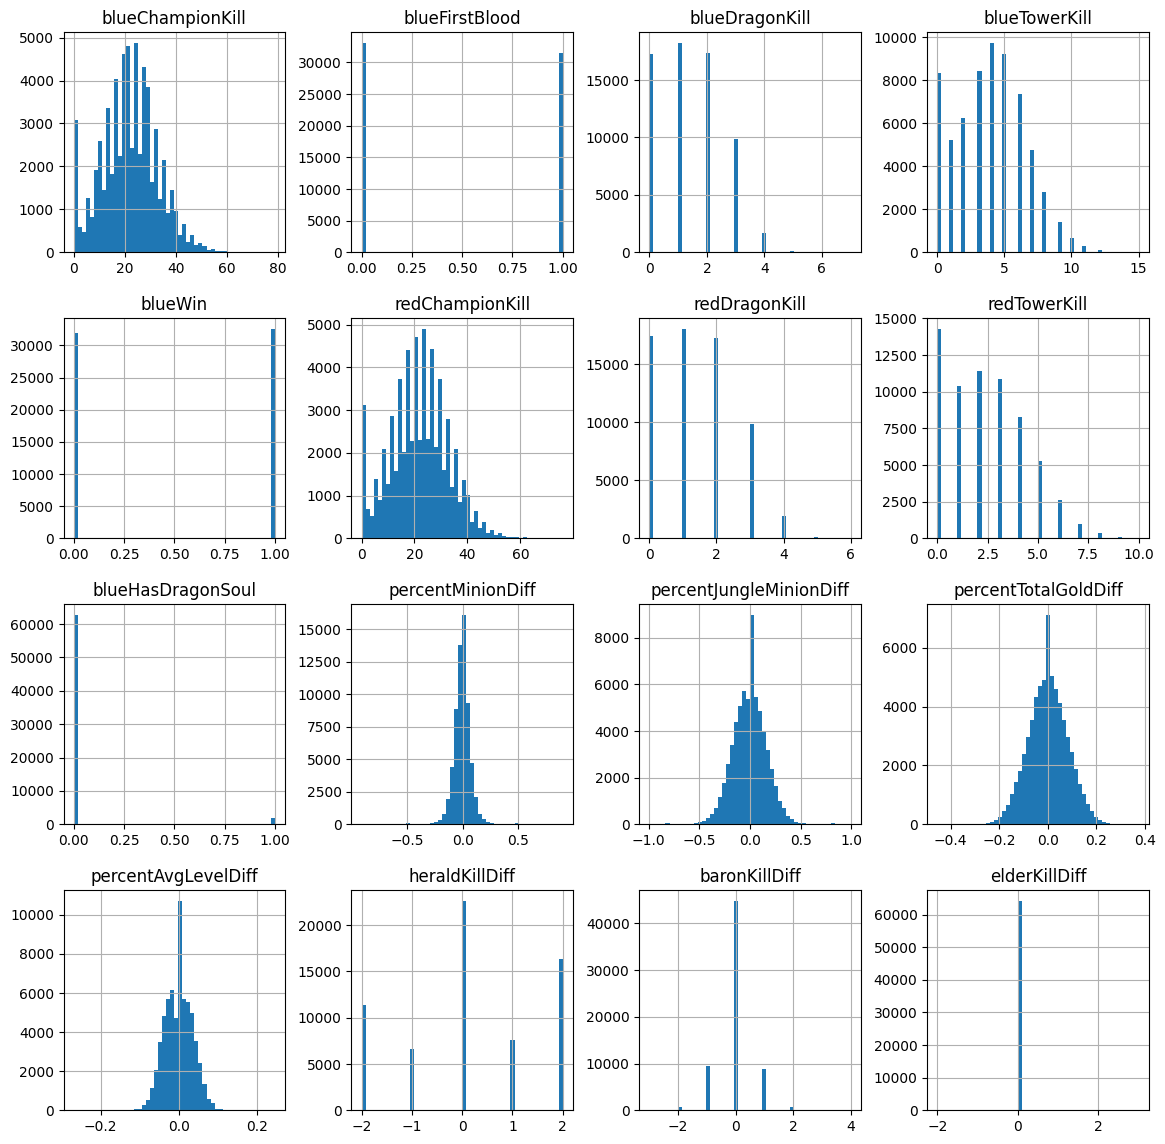

In [52]:
# Visualize data
# Look at feature hists

dataset.hist(bins=50, figsize=(14,14))
plt.show()

In [ ]:
# Look at correlations
corr_matrix = dataset.corr()
corr_plot , corr_ax = plt.subplots(figsize=(20,20))

sns.heatmap(data=corr_matrix, annot=True, ax=corr_ax)

plt.show()

In [51]:
### Feature engineering

# Use percent difference in average levels
avgLevelDiff  = dataset.blueAvgPlayerLevel - dataset.redAvgPlayerLevel
percentAvgLevelDiff = avgLevelDiff / (dataset.blueAvgPlayerLevel + dataset.redAvgPlayerLevel)

dataset.insert(len(dataset.columns), 'percentAvgLevelDiff', percentAvgLevelDiff)

# Combine blue and red dragon soul, 1 if blue, -1 if red, 0 if neither
for idx, row in dataset.iterrows():
    if row['redHasDragonSoul'] == 1:
        row['blueHasDragonSoul'] = -1

# Combine neutral objectives to differences
heraldKillDiff = dataset.blueRiftHeraldKill - dataset.redRiftHeraldKill
baronKillDiff = dataset.blueBaronKill - dataset.redBaronKill
elderKillDiff = dataset.blueDragonElderKill - dataset.redDragonElderKill

dataset.insert(len(dataset.columns), 'heraldKillDiff', heraldKillDiff)
dataset.insert(len(dataset.columns), 'baronKillDiff', baronKillDiff)
dataset.insert(len(dataset.columns), 'elderKillDiff', elderKillDiff)



# Remove combined features
cut_features = ['blueAvgPlayerLevel',
                'redAvgPlayerLevel',
                'redHasDragonSoul',
                'blueRiftHeraldKill',
                'blueBaronKill',
                'blueDragonElderKill',
                'redRiftHeraldKill',
                'redBaronKill',
                'redDragonElderKill',
               ]

dataset.drop(columns=cut_features, inplace=True)

# Remove unimportant features
unimportant_features = ['blueInhibitorKill',
                        'redInhibitorKill'
                       ]

dataset.drop(columns=unimportant_features, inplace=True)



In [ ]:
# Look at correlation scatterplots
utils.corr_scatter_plot(dataset, dataset.percentTotalGoldDiff, dataset.blueWin, alpha=0.2)

In [ ]:
# Compare features based on win/loss
utils.binary_comparison_plot(dataset, 'blueWin')

In [34]:
# Experimental feature transforms

eps = 0.00001

avgDragonKillDiff  = dataset.blueDragonKill - dataset.redDragonKill
percentDragonDiff = avgDragonKillDiff / (dataset.blueDragonKill + dataset.redDragonKill + eps)

avgTowerKillDiff  = dataset.blueTowerKill - dataset.redTowerKill
percentTowerDiff = avgTowerKillDiff / (dataset.blueTowerKill + dataset.redTowerKill + eps)

dataset.insert(len(dataset.columns), 'percentDragonDiff', percentDragonDiff)
dataset.insert(len(dataset.columns), 'percentTowerDiff', percentTowerDiff)



# Remove combined features
cut_features = ['blueDragonKill',
                'redDragonKill',
                'blueTowerKill',
                'redTowerKill',
               ]

dataset.drop(columns=cut_features, inplace=True)


In [53]:
# Prepare training and validation sets and labels

valid_frac = 0.2

train_set, valid_set = train_test_split(dataset, test_size=valid_frac, random_state=RANDOM_SEED)

# Separate wins
train_wins = train_set.pop('blueWin')
valid_wins = valid_set.pop('blueWin')


print(dataset.shape, train_set.shape, valid_set.shape)


(64556, 16) (51644, 15) (12912, 15)


In [57]:
# Scale features

scaler = StandardScaler()

for set in [train_set, valid_set]:
    set[['blueChampionKill', 'redChampionKill']] = scaler.fit_transform(set[['blueChampionKill', 'redChampionKill']])


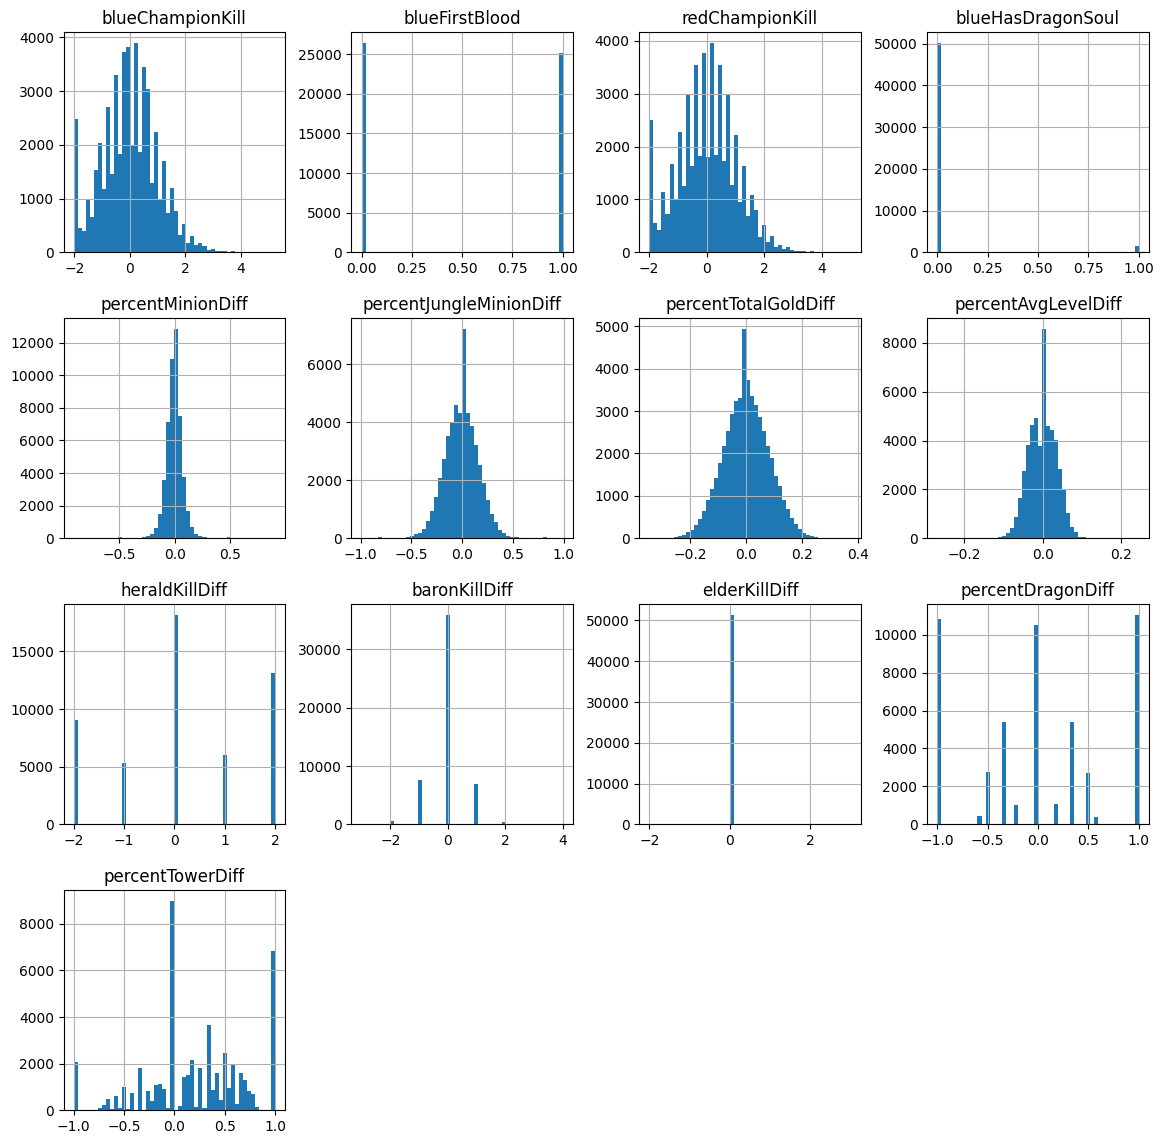

In [37]:
train_set.hist(bins=50, figsize=(14,14))
plt.show()

In [59]:
# Try logistic regression, SGD classifier with scikit-learn

# Initialize models
sgd_model = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000)
lr_model = LogisticRegression(penalty='l2', max_iter=1000)

# Check accuracy with cross validation
sgd_cv = cross_val_score(sgd_model, train_set, train_wins, cv=10, scoring="accuracy")
lr_cv = cross_val_score(lr_model, train_set, train_wins, cv=10, scoring="accuracy")

print("SGD CV training accuracy: ", sgd_cv)
print("LR CV training accuracy: ", lr_cv)

# Check validation accuracy
sgd_model.fit(train_set, train_wins)
lr_model.fit(train_set, train_wins)
sgd_valid_pred = sgd_model.predict(valid_set)
lr_valid_pred = lr_model.predict(valid_set)

sgd_acc = accuracy_score(valid_wins, sgd_valid_pred) 
lr_acc = accuracy_score(valid_wins, lr_valid_pred)

print("SGD validation accuracy: ", sgd_acc)
print("LR validation accuracy: ", lr_acc)


SGD CV training accuracy:  [0.84162633 0.84065828 0.83717328 0.84143272 0.81893881 0.84585593
 0.84682417 0.84604957 0.85224632 0.83268784]
LR CV training accuracy:  [0.84588577 0.84336883 0.84220716 0.84453049 0.84178931 0.85282727
 0.85263362 0.85243997 0.85243997 0.84275755]
SGD validation accuracy:  0.8409231722428748
LR validation accuracy:  0.8454925650557621


In [61]:
# Try ANN with tensorflow

# Convert dataframes to tensors
train_data = tf.convert_to_tensor(train_set, dtype='float32')
train_labels = tf.convert_to_tensor(train_wins, dtype='float32')

valid_data = tf.convert_to_tensor(valid_set, dtype='float32')
valid_labels = tf.convert_to_tensor(valid_wins, dtype='float32')

input_shape = [train_data.shape[1]]

# Define NN
dnn = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Choose optimizer and loss function
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
loss_func = tf.keras.losses.BinaryCrossentropy()

# Compile and train model
dnn.compile(optimizer=optimizer, loss = loss_func, metrics=['binary_accuracy'])
dnn.fit(x=train_data, y=train_labels, epochs = 20, batch_size=64)

# Test model
dnn.evaluate(valid_data, valid_labels)

Epoch 1/20
807/807 [==============================] - 11s 12ms/step - loss: 0.3682 - binary_accuracy: 0.8285
Epoch 2/20
807/807 [==============================] - 10s 12ms/step - loss: 0.3360 - binary_accuracy: 0.8386
Epoch 3/20
807/807 [==============================] - 10s 12ms/step - loss: 0.3324 - binary_accuracy: 0.8408
Epoch 4/20
807/807 [==============================] - 10s 12ms/step - loss: 0.3320 - binary_accuracy: 0.8393
Epoch 5/20
807/807 [==============================] - 9s 11ms/step - loss: 0.3308 - binary_accuracy: 0.8406
Epoch 6/20
807/807 [==============================] - 9s 12ms/step - loss: 0.3304 - binary_accuracy: 0.8408
Epoch 7/20
807/807 [==============================] - 10s 12ms/step - loss: 0.3294 - binary_accuracy: 0.8396
Epoch 8/20
807/807 [==============================] - 9s 11ms/step - loss: 0.3280 - binary_accuracy: 0.8406
Epoch 9/20
807/807 [==============================] - 9s 12ms/step - loss: 0.3289 - binary_accuracy: 0.8406
Epoch 10/20
807/807 [==

[0.3251950442790985, 0.8449504375457764]

In [60]:
# Try gradient boost with XGB

# Convert pandas dataframes to xgb DMatrices
train_dm = xgb.DMatrix(train_set, train_wins)
valid_dm = xgb.DMatrix(valid_set, valid_wins)

# Set hyperparameters
xgb_params = {'objective': 'binary:logistic',
              'tree_method': 'hist',
              'learning_rate': 0.1,
              'eval_metric': 'logloss',
              'max_depth': 6,
              'subsample': 0.8,
              'colsample_bytree': 1,
              'verbosity': 2
            }
evals = [(train_dm, 'train'), (valid_dm, 'validation')]

# Train model
xgb_results = xgb.cv(params=xgb_params,
                     dtrain=train_dm,
                     verbose_eval=10,
                     early_stopping_rounds=10,
                     nfold=10,
                     metrics=['auc', 'error'],
                     num_boost_round=1000)

xgb_results.head(10)



[0]	train-auc:0.93341+0.00027	train-error:0.15548+0.00108	test-auc:0.92947+0.00329	test-error:0.16050+0.00472
[10]	train-auc:0.94018+0.00031	train-error:0.14782+0.00073	test-auc:0.93531+0.00304	test-error:0.15504+0.00441
[20]	train-auc:0.94193+0.00028	train-error:0.14660+0.00076	test-auc:0.93614+0.00295	test-error:0.15471+0.00420
[30]	train-auc:0.94309+0.00026	train-error:0.14575+0.00062	test-auc:0.93653+0.00283	test-error:0.15427+0.00431
[35]	train-auc:0.94349+0.00026	train-error:0.14544+0.00073	test-auc:0.93664+0.00282	test-error:0.15448+0.00433


,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.933409,0.000272,0.155479,0.001076,0.929474,0.003285,0.160503,0.004722
1,0.935717,0.000454,0.151931,0.001196,0.931725,0.003217,0.158005,0.004588
2,0.937262,0.000369,0.150483,0.001202,0.933110,0.002924,0.156514,0.004697
3,0.937933,0.000327,0.149818,0.001007,0.933752,0.002967,0.155546,0.004389
4,0.938398,0.000307,0.149470,0.000840,0.934120,0.003004,0.155526,0.004303
5,0.938767,0.000365,0.149031,0.000714,0.934332,0.002985,0.155449,0.004067
6,0.939083,0.000376,0.148725,0.000675,0.934536,0.002960,0.155120,0.004278
7,0.939411,0.000335,0.148558,0.000712,0.934809,0.002965,0.155526,0.004268
8,0.939713,0.000321,0.148222,0.000555,0.934958,0.003012,0.155352,0.003986
9,0.939954,0.000319,0.147940,0.000729,0.935084,0.003059,0.155468,0.004329
